In [0]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/Colab Notebooks/my_project1/deep-learning/utils'
#sys.path.append(folder)
os.chdir(folder)

In [0]:
#from torchvision import transforms
import torch.nn as nn
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
#from models.resnet import *
from models.resnet_gradcam import ResNet18_GradCam
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from albumentations import *
from albumentations.pytorch import ToTensor
from gradcam import *
from albumentation import AlbumentationImageDataset
import matplotlib.pyplot as plt

In [9]:
model_obj = ResNet18_GradCam()
#model_obj = resnet_gradcam.ResNet18_Gradcam()
# create object for Model
device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model_obj)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Apply Albumentation

In [0]:
patch_size = 32
custom_transforms = [
       Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
       HorizontalFlip(),
       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
       ToTensor()
    ]

train_transforms = Compose(custom_transforms)
test_transform = Compose(
    [
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     ToTensor(),
     ])
data_set_obj = DataSetInfo("cifa", "./data")
train_transforms = AlbumentationImageDataset(data_set_obj, transforms = train_transforms)
test_transforms = AlbumentationImageDataset(data_set_obj, transforms = test_transform)


### Get Train and Test data set

In [11]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [12]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=64)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Display some training images

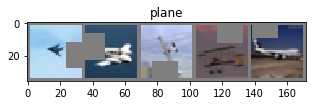

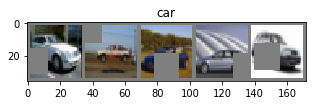

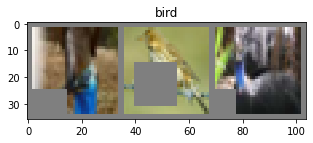

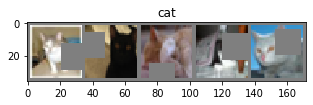

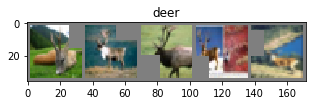

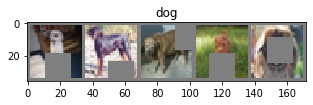

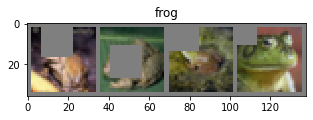

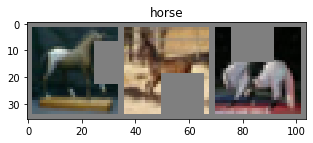

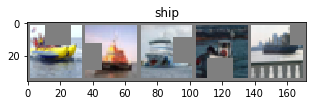

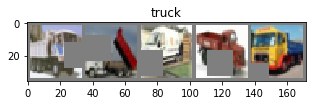

In [15]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images, labels = iter(train_loader).next()
for i in range(len(classes)):
  index = [j for j in range(len(labels)) if labels[j] == i]
  img = torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=False)
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(classes[i])



### display one image to check cutout

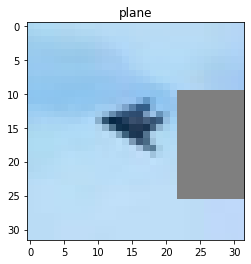

In [18]:
Plot.image_show(images[0], title=classes[0])

### Run Model

In [20]:
import torch.nn as nn
optimizer = helper_obj.get_l2_regularizer()
scheduler = helper_obj.get_one_cycle_lr(optimizer=optimizer, lr=0.001)
EPOCHS = 21
#l1_factor=0.0001

train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS):
    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    if epoch < EPOCHS-1:
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=False, trueclassified_required=False)
    else:
        # store only last epochsreult for misclassfied and trueclassified images
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=True, trueclassified_required=True)
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])
miscassified_images = test_obj.misclassified_images
correctcassified_images = test_obj.trueclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=2.018612861633301 Batch_id=781 Accuracy=46.50: 100%|██████████| 782/782 [01:06<00:00, 11.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 5412/10000 (54.12%)

EPOCH: 2


Train Set: Train Loss=0.8625228404998779 Batch_id=781 Accuracy=59.21: 100%|██████████| 782/782 [01:07<00:00, 11.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 6622/10000 (66.22%)

EPOCH: 3


Train Set: Train Loss=1.3827990293502808 Batch_id=781 Accuracy=65.77: 100%|██████████| 782/782 [01:08<00:00, 11.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 7297/10000 (72.97%)

EPOCH: 4


Train Set: Train Loss=1.2031317949295044 Batch_id=781 Accuracy=70.09: 100%|██████████| 782/782 [01:09<00:00, 11.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 7239/10000 (72.39%)

EPOCH: 5


Train Set: Train Loss=0.44285398721694946 Batch_id=781 Accuracy=71.76: 100%|██████████| 782/782 [01:10<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 7638/10000 (76.38%)

EPOCH: 6


Train Set: Train Loss=1.0334893465042114 Batch_id=781 Accuracy=72.43: 100%|██████████| 782/782 [01:10<00:00, 11.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 7269/10000 (72.69%)

EPOCH: 7


Train Set: Train Loss=1.001640796661377 Batch_id=781 Accuracy=73.48: 100%|██████████| 782/782 [01:10<00:00, 11.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 6838/10000 (68.38%)

EPOCH: 8


Train Set: Train Loss=0.6959595084190369 Batch_id=781 Accuracy=74.09: 100%|██████████| 782/782 [01:10<00:00, 11.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 7538/10000 (75.38%)

EPOCH: 9


Train Set: Train Loss=0.594438910484314 Batch_id=781 Accuracy=75.03: 100%|██████████| 782/782 [01:10<00:00, 11.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 7190/10000 (71.90%)

EPOCH: 10


Train Set: Train Loss=1.3153979778289795 Batch_id=781 Accuracy=75.43: 100%|██████████| 782/782 [01:10<00:00, 11.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 7481/10000 (74.81%)

EPOCH: 11


Train Set: Train Loss=0.7799980044364929 Batch_id=781 Accuracy=76.21: 100%|██████████| 782/782 [01:10<00:00, 11.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 6726/10000 (67.26%)

EPOCH: 12


Train Set: Train Loss=1.0485506057739258 Batch_id=781 Accuracy=76.82: 100%|██████████| 782/782 [01:09<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 8047/10000 (80.47%)

EPOCH: 13


Train Set: Train Loss=0.7881219983100891 Batch_id=781 Accuracy=78.10: 100%|██████████| 782/782 [01:09<00:00, 11.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7812/10000 (78.12%)

EPOCH: 14


Train Set: Train Loss=0.7559738159179688 Batch_id=781 Accuracy=79.22: 100%|██████████| 782/782 [01:10<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 7866/10000 (78.66%)

EPOCH: 15


Train Set: Train Loss=0.5859324336051941 Batch_id=781 Accuracy=80.72: 100%|██████████| 782/782 [01:10<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8161/10000 (81.61%)

EPOCH: 16


Train Set: Train Loss=0.13489601016044617 Batch_id=781 Accuracy=83.19: 100%|██████████| 782/782 [01:10<00:00, 11.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8329/10000 (83.29%)

EPOCH: 17


Train Set: Train Loss=0.8438105583190918 Batch_id=781 Accuracy=85.61: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8702/10000 (87.02%)

EPOCH: 18


Train Set: Train Loss=0.5002045631408691 Batch_id=781 Accuracy=89.10: 100%|██████████| 782/782 [01:10<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 9029/10000 (90.29%)

EPOCH: 19


Train Set: Train Loss=0.28670042753219604 Batch_id=781 Accuracy=91.77: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 9204/10000 (92.04%)

EPOCH: 20


Train Set: Train Loss=0.2041163146495819 Batch_id=781 Accuracy=92.97: 100%|██████████| 782/782 [01:09<00:00, 11.18it/s]



Test set: Average loss: 0.0036, Accuracy: 9211/10000 (92.11%)

Maximum Training Accuracy =  92.97
Maximum Testing Accuracy =  92.11


In [0]:
from google.colab import files
# print("Our model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')
files.download('checkpoint.pth')

### Visualizing gradcam results for correctly classified images in layer4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


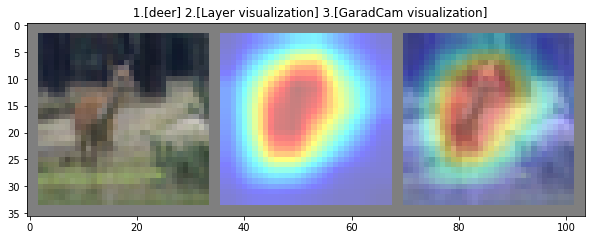

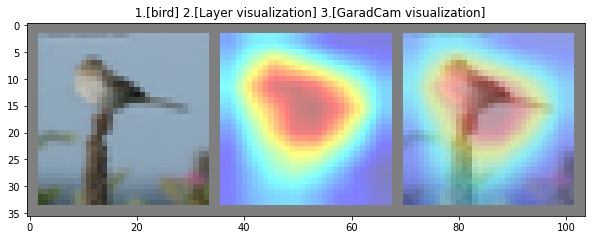

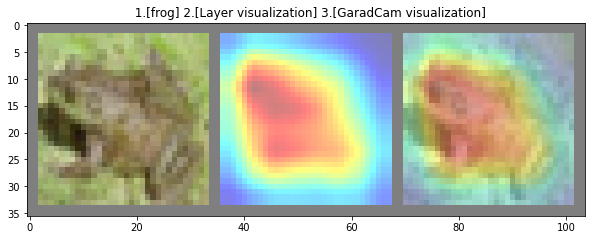

In [41]:
from torchvision.utils import make_grid
num_img = 3
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([correctcassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, correctcassified_images[index][0])
  images.extend([correctcassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[{0}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[correctcassified_images[index][2].item()])
  Plot.image_show1(make_grid(images, nrow=5), title=label, download_image="gradcam_correctclassified.png")

###Visualizing Gradcam results in all 4 layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


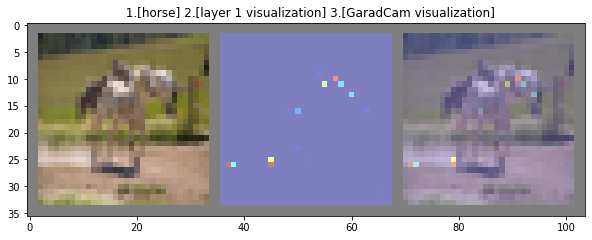

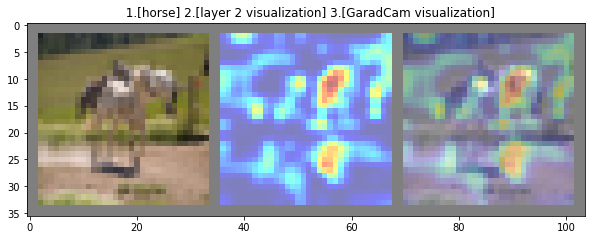

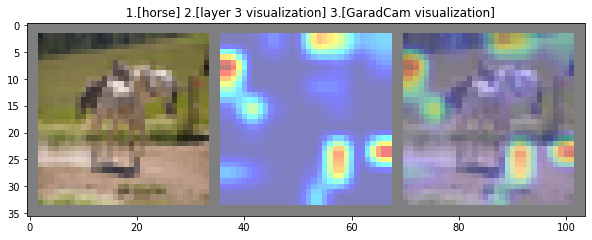

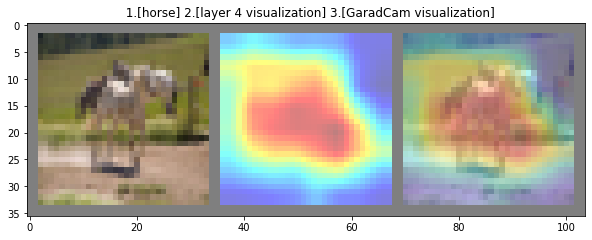

In [42]:
image = correctcassified_images[6] #take one random image from correctly classidfied images
layer_details = [model.layer1, model.layer2, model.layer3, model.layer4]
for i, model_layer in enumerate(layer_details):
    images = []
    grad_cam = GradCAM(model, model_layer)
    mask, _ = grad_cam(torch.stack([image[0]]))
    heatmap, result = visualize_cam(mask, image[0])
    images.extend([image[0].cpu(), heatmap, result])
    label = "  1.[{0}] 2.[layer {1} visualization] 3.[GaradCam visualization]".format(classes[image[2].item()], i+1)
    Plot.image_show(make_grid(images, nrow=5), title=label, download_image="gradcam_layer{0}.png".format(i+1))



### Visualizing gradcam results for miss classified images in layer4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


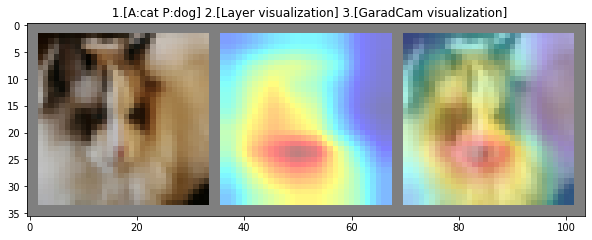

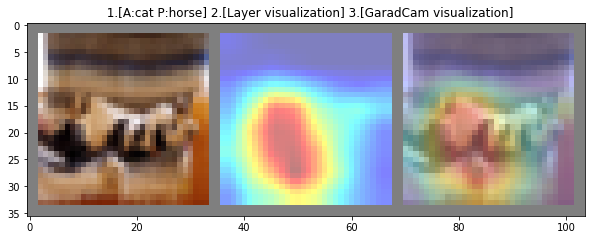

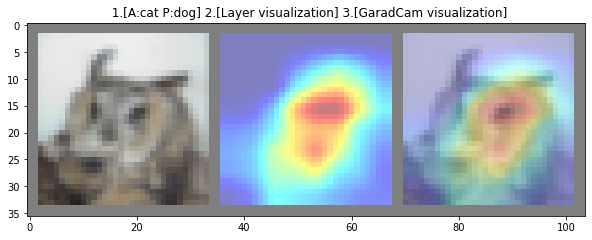

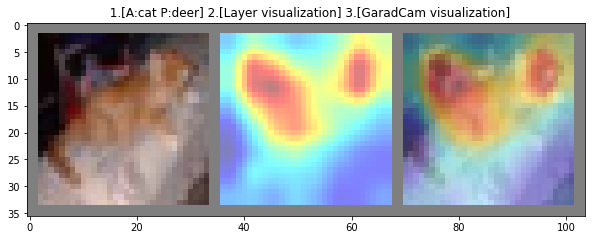

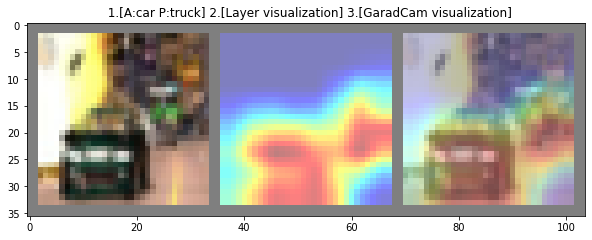

In [44]:
num_img = 5
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([miscassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, miscassified_images[index][0])
  images.extend([miscassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[A:{0} P:{1}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[miscassified_images[index][2].item()],classes[miscassified_images[index][1].item()])
  Plot.image_show(make_grid(images, nrow=5), title=label,, download_image="gradcam_misclassified.png")